In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [3]:
rating_columns = ['userId', 'movieId', 'rating', 'timestamp']
rating_table = pd.read_table('./ml-100k/u.data', sep='\t', header=None, names=rating_columns, engine = 'python')
df=rating_table
df

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [15]:
userid_list = df["userId"].unique().tolist()
userid_dict = {x: i for i, x in enumerate(userid_list)}
movieid_list = df["movieId"].unique().tolist()
movieid_dict = {x: i for i, x in enumerate(movieid_list)}
df["user"] = df["userId"].map(userid_dict)
df["movie"] = df["movieId"].map(movieid_dict)
df["rating"] = df["rating"].values.astype(np.float32)
min_rating = min(df["rating"])


In [19]:
x = df[["user", "movie"]].values
min_rating = min(df["rating"])
max_rating=max(df['rating'])
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
indice_75 = int(0.75 * df.shape[0])
indice_85=int(0.9 * df.shape[0])
x_train, x_val,x_test, y_train, y_val,y_test = (
    x[:indice_75],
    x[indice_75:indice_85],
    x[indice_85:],
    y[:indice_75],
    y[indice_75:indice_85],
    y[indice_85:],
)

In [26]:
from keras import backend as K
class NCF(keras.Model):
    def __init__(self, users_len, movies_len, embedding_size, **kwargs):
        super(NCF, self).__init__(**kwargs)
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            users_len,
            50,
            embeddings_initializer="uniform",
        )
        self.user_bias = layers.Embedding(
            users_len, 
            1, 
            embeddings_initializer="uniform",
        )
        self.movie_embedding = layers.Embedding(
            movies_len,
            50,
            embeddings_initializer="uniform",
        )
        self.movie_bias = layers.Embedding(
            movies_len, 
            1, 
            embeddings_initializer="uniform",
            
        )

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        x = dot_user_movie + user_bias + movie_bias
        return tf.nn.sigmoid(x)

def NMSE_metric(y_true, y_pred):
    fenzi = K.mean(K.square(y_true - y_pred))
    fenmu=K.mean(K.square(y_true))
    return float(fenzi)/float(fenmu)

model = NCF(len(userid_list), len(movieid_list), 50)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001),metrics=[NMSE_metric]
)


D:\anaconda\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [27]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=8,
    verbose=1,
    validation_data=(x_val, y_val),
)


Epoch 1/8
1172/1172 [==============================] - 2s 1ms/step - loss: 0.6522 - NMSE_metric: 0.1621 - val_loss: 0.6400 - val_NMSE_metric: 0.1459
Epoch 2/8
1172/1172 [==============================] - 1s 989us/step - loss: 0.6285 - NMSE_metric: 0.1392 - val_loss: 0.6312 - val_NMSE_metric: 0.1369
Epoch 3/8
1172/1172 [==============================] - 1s 952us/step - loss: 0.6198 - NMSE_metric: 0.1310 - val_loss: 0.6263 - val_NMSE_metric: 0.1324
Epoch 4/8
1172/1172 [==============================] - 1s 971us/step - loss: 0.6164 - NMSE_metric: 0.1279 - val_loss: 0.6225 - val_NMSE_metric: 0.1292
Epoch 5/8
1172/1172 [==============================] - 1s 995us/step - loss: 0.6155 - NMSE_metric: 0.1272 - val_loss: 0.6229 - val_NMSE_metric: 0.1298
Epoch 6/8
1172/1172 [==============================] - 1s 968us/step - loss: 0.6154 - NMSE_metric: 0.1271 - val_loss: 0.6242 - val_NMSE_metric: 0.1311
Epoch 7/8
1172/1172 [==============================] - 1s 979us/step - loss: 0.6152 - NMSE_metri

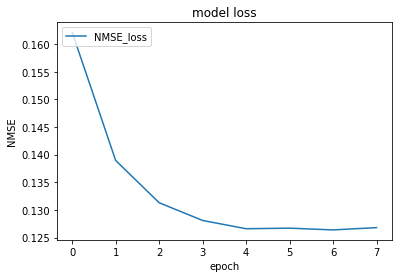

In [22]:
plt.plot(history.history["NMSE_metric"])
plt.title("model loss")
plt.ylabel("NMSE")
plt.xlabel("epoch")
plt.legend(["NMSE_loss"], loc="upper left")
plt.show()

In [25]:
score, acc = model.evaluate(x_test, y_test,
                            batch_size=64)
print('Test score:', score)
print('Test accuracy:', acc)

157/157 [==============================] - 0s 588us/step - loss: 0.6158 - NMSE_metric: 0.1275
Test score: 0.6158482432365417
Test accuracy: 0.12750530242919922
